In [1]:
# ============================================================
# 04_interpretability.ipynb
# Model Interpretability (Global + Local Explanations)
# ============================================================

import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.inspection import permutation_importance

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from config import PROCESSED_PATH, MODEL_PATH

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 200)

print("PROCESSED_PATH:", PROCESSED_PATH)
print("MODEL_PATH:", MODEL_PATH)


PROCESSED_PATH: /Users/loictiemani/Documents/sla-risk-prediction/data/processed/sla_cases_clean.csv
MODEL_PATH: /Users/loictiemani/Documents/sla-risk-prediction/models/sla_rf_model.pkl


In [2]:
# 1️⃣ Load dataset + model artifact
df = pd.read_csv(PROCESSED_PATH)
TARGET_COL = "sla_breach"

artifact = joblib.load(MODEL_PATH)

# artifact can be dict or a model; handle both
if isinstance(artifact, dict):
    model = artifact["model"]
    threshold = artifact.get("threshold", 0.5)
    feature_cols = artifact.get("feature_columns", [c for c in df.columns if c != TARGET_COL])
else:
    model = artifact
    threshold = 0.5
    feature_cols = [c for c in df.columns if c != TARGET_COL]

X = df[feature_cols].copy()
y = df[TARGET_COL].astype(int)

print("Loaded dataset:", df.shape)
print("Using #features:", X.shape[1])
print("Threshold:", threshold)


Loaded dataset: (5000, 40)
Using #features: 39
Threshold: 0.95


sla_target_days                       0.284045
client_delay_per_sla                  0.181849
stage_time_ratio                      0.156118
docs_per_sla                          0.115497
case_type_Relocation                  0.026367
client_response_delay_days            0.024677
case_type_Visa Renewal                0.024374
load_x_reassign                       0.023424
case_type_Tax                         0.020986
case_type_Work Permit                 0.018181
days_in_stage                         0.017035
office_load                           0.013278
documents_missing                     0.009741
reassignment_count                    0.009640
case_type_Payroll                     0.009444
office_id                             0.009308
client_delay_bucket_15-30             0.007944
processing_stage_Government Review    0.007599
document_complexity_Low               0.005467
client_delay_bucket_1-7               0.003465
dtype: float64

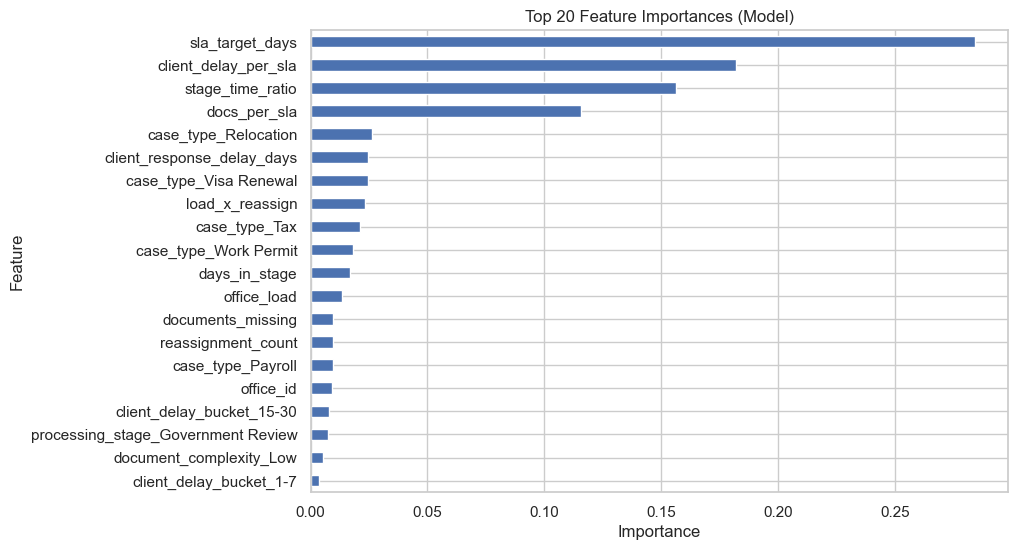

In [3]:
# 2️⃣ Global interpretability: native feature importance (tree models)
if hasattr(model, "feature_importances_"):
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    display(importances.head(20))

    plt.figure(figsize=(9,6))
    importances.head(20).sort_values().plot(kind="barh")
    plt.title("Top 20 Feature Importances (Model)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("Model has no native feature_importances_. We'll use permutation importance.")



sla_target_days                       0.056625
client_delay_per_sla                  0.035325
stage_time_ratio                      0.031925
docs_per_sla                          0.012800
processing_stage_Government Review    0.007525
load_x_reassign                       0.006900
client_response_delay_days            0.004150
office_load                           0.003900
days_in_stage                         0.002750
reassignment_count                    0.002675
documents_missing                     0.002025
document_complexity_Low               0.001950
office_id                             0.001125
office_load_bucket_very_high          0.000950
client_delay_bucket_15-30             0.000750
processing_stage_Intake               0.000525
country_UK                            0.000500
country_US                            0.000475
client_delay_bucket_8-14              0.000375
priority_Urgent                       0.000350
dtype: float64

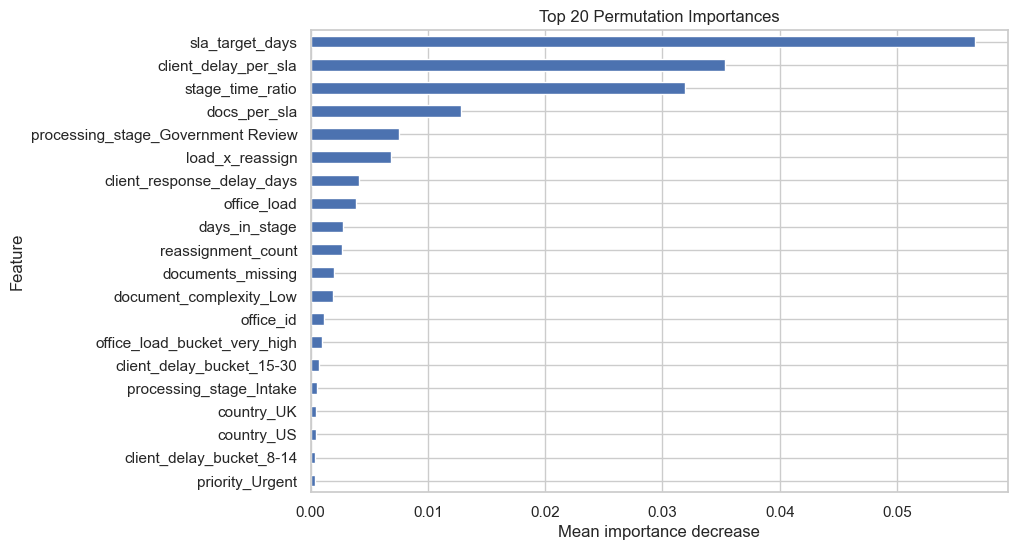

In [4]:
# 3️⃣ Permutation importance (works for any model)
# Note: can be a bit slower; keep n_repeats modest
perm = permutation_importance(model, X, y, n_repeats=8, random_state=42, n_jobs=-1)

perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
display(perm_imp.head(20))

plt.figure(figsize=(9,6))
perm_imp.head(20).sort_values().plot(kind="barh")
plt.title("Top 20 Permutation Importances")
plt.xlabel("Mean importance decrease")
plt.ylabel("Feature")
plt.show()


In [6]:
# 4️⃣ Local explanations (SHAP if available; fallback to "reason codes")
# SHAP gives best local explanations; if not installed, fallback.

def try_import_shap():
    try:
        import shap
        return shap
    except Exception as e:
        print("SHAP not available:", str(e))
        return None

shap = try_import_shap()


SHAP not available: No module named 'shap'


In [7]:
# 5️⃣ If SHAP is available: compute local explanations for a sample
if shap is not None:
    # SHAP can be heavy; sample for speed
    sample = X.sample(400, random_state=42)

    # Use TreeExplainer if possible (RandomForest, XGBoost, etc.)
    explainer = shap.Explainer(model, sample)
    shap_values = explainer(sample)

    # Global summary plot
    shap.plots.beeswarm(shap_values, max_display=20)

    # Local explanation for top-risk cases
    proba = model.predict_proba(sample)[:, 1] if hasattr(model, "predict_proba") else model.predict(sample)
    top_idx = np.argsort(proba)[-5:][::-1]

    for i in top_idx:
        print("\n--- Local explanation for a high-risk case ---")
        print("Predicted risk:", round(float(proba[i]), 3))
        row = sample.iloc[i:i+1]
        display(row)

        shap.plots.waterfall(shap_values[i], max_display=12)
else:
    print("Skipping SHAP plots. Using a lightweight fallback below.")


Skipping SHAP plots. Using a lightweight fallback below.


In [8]:
# 6️⃣ Fallback local explanation (works without SHAP)
# Create simple "reason codes" using feature contributions proxy:
# For each high-risk case, list the top 5 features farthest from median.

proba_all = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else model.predict(X)
risk_df = X.copy()
risk_df["predicted_risk"] = proba_all
risk_df["actual_breach"] = y.values

top_cases = risk_df.sort_values("predicted_risk", ascending=False).head(5)
display(top_cases[["predicted_risk", "actual_breach"]])

medians = X.median(numeric_only=True)

def top_reason_codes(row, k=5):
    # only numeric columns for this heuristic
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    diffs = (row[numeric_cols] - medians[numeric_cols]).abs().sort_values(ascending=False)
    return list(diffs.head(k).index)

for idx, row in top_cases.iterrows():
    print("\nCase index:", idx, "| Predicted risk:", round(row["predicted_risk"], 3), "| Actual breach:", int(row["actual_breach"]))
    reasons = top_reason_codes(row, k=6)
    print("Top reason codes (heuristic):", reasons)


,predicted_risk,actual_breach
2500,1.0,1
1711,1.0,1
3532,1.0,1
3530,1.0,1
1705,1.0,1



Case index: 2500 | Predicted risk: 1.0 | Actual breach: 1
Top reason codes (heuristic): ['load_x_reassign', 'days_in_stage', 'office_load', 'sla_target_days', 'client_response_delay_days', 'documents_missing']

Case index: 1711 | Predicted risk: 1.0 | Actual breach: 1
Top reason codes (heuristic): ['load_x_reassign', 'office_load', 'sla_target_days', 'client_response_delay_days', 'days_in_stage', 'office_id']

Case index: 3532 | Predicted risk: 1.0 | Actual breach: 1
Top reason codes (heuristic): ['load_x_reassign', 'client_response_delay_days', 'days_in_stage', 'sla_target_days', 'office_load', 'office_id']

Case index: 3530 | Predicted risk: 1.0 | Actual breach: 1
Top reason codes (heuristic): ['load_x_reassign', 'office_load', 'days_in_stage', 'office_id', 'client_response_delay_days', 'reassignment_count']

Case index: 1705 | Predicted risk: 1.0 | Actual breach: 1
Top reason codes (heuristic): ['load_x_reassign', 'office_load', 'client_response_delay_days', 'sla_target_days', 'day

In [9]:

# 7️⃣ Write 3–6 operational insights (store as markdown-style text)
# (This becomes gold for your README / SOP)
insights = [
    "High SLA breach risk is associated with higher office_load and workflow friction signals (e.g., reassignment_count, stage_time_ratio).",
    "Client-side delays (client_response_delay_days) and documentation gaps (documents_missing / missing_docs_bucket) increase predicted risk.",
    "Stage-related features (processing_stage_* and stage_time_ratio) help identify bottlenecks (e.g., Government Review vs Intake).",
    "A lower threshold can be used to maximize recall for early warning, with human review mitigating false positives."
]
for i, s in enumerate(insights, 1):
    print(f"{i}. {s}")


1. High SLA breach risk is associated with higher office_load and workflow friction signals (e.g., reassignment_count, stage_time_ratio).
2. Client-side delays (client_response_delay_days) and documentation gaps (documents_missing / missing_docs_bucket) increase predicted risk.
3. Stage-related features (processing_stage_* and stage_time_ratio) help identify bottlenecks (e.g., Government Review vs Intake).
4. A lower threshold can be used to maximize recall for early warning, with human review mitigating false positives.
